<a href="https://colab.research.google.com/github/akshat-suwalka/Classification-of-Blood-vessels-leaking-time-in-an-Eye/blob/main/Classification_in_AM_PM_by_Fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library

In [ ]:
pip install fastai2

In [ ]:
import fastai2
from fastai2.vision.all import *

#Dataset Functions

In [ ]:
class TupleImage(tuple):
    "A tuple of PILImages"
    def show(self, ctx=None, **kwargs): 
        n = len(self)
        img0, img1, img2= self[0], self[n//2], self[n-2]
        if not isinstance(img1, Tensor):
            t0, t1,t2 = tensor(img0), tensor(img1),tensor(img2)
            t0, t1,t2 = t0.permute(2,0,1), t1.permute(2,0,1),t2.permute(2,0,1)
        else: t0, t1,t2 = img0, img1,img2
        return show_image(torch.cat([t0,t1,t2], dim=2), ctx=ctx, **kwargs)

In [ ]:
class ImageTupleTfm(Transform):
    "A wrapper to hold the data on path format"
    def __init__(self, random_sample=False, seq_len=20):
        self.seq_len = seq_len
        self.random_sample = random_sample
        
    def encodes(self, path):
        "Get a list of images files for folder path"
        if self.random_sample:
            frames = path.ls()
            return TupleImage(tuple(PILImage.create(f) for f in sort_files(L(random.sample(list(frames), self.seq_len)))))
        else:
            frames = sort_files(path.ls())
            n_frames = len(frames)
            first_idx = random.randint(0, n_frames-self.seq_len)
            s = slice(first_idx, first_idx+self.seq_len)
            return TupleImage(tuple(PILImage.create(f) for f in frames[s]))

In [ ]:
def get_action_dataloaders(files, bs=8, image_size=64, seq_len=12, val_idxs=None, random_sample=False, **kwargs):
    "Create a dataloader with `val_idxs` splits"
    splits = RandomSplitter()(files) if val_idxs is None else IndexSplitter(val_idxs)(files)
    itfm = ImageTupleTfm(random_sample=random_sample, seq_len=seq_len)
    ds = Datasets(files, tfms=[[itfm], [parent_label, Categorize]], splits=splits)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size), ToTensor], 
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], drop_last=True, **kwargs)
    return dls

In [ ]:
def get_sequence_paths(path):
    " gets all sequences folders paths"
    sequence_paths = []
    for actions in path.ls():
        sequence_paths += actions.ls()
    return sequence_paths

In [ ]:
def sort_files(path_seq):
    return path_seq.sorted(key=lambda f: float(f.with_suffix('').name[7] if f.with_suffix('').name[9] == 'm' else f.with_suffix('').name[7:10]))

#Dataset Loading

In [ ]:
PATH = Path.cwd().parent/'data'
Path.BASE_PATH = PATH

In [ ]:
/content/drive/My Drive/fastai_train_patches

In [ ]:
IMAGE_PATH = PATH/'/content/drive/My Drive/train_patches'
files = get_sequence_paths(IMAGE_PATH)

In [ ]:
files

(#746) [Path('/content/drive/My Drive/fastai_train_patches/AM/032 AM 9.5 min.tif'),Path('/content/drive/My Drive/fastai_train_patches/AM/032 AM 5 min.tif'),Path('/content/drive/My Drive/fastai_train_patches/AM/032 AM 9 min.tif'),Path('/content/drive/My Drive/fastai_train_patches/AM/032 AM 6 min.tif'),Path('/content/drive/My Drive/fastai_train_patches/AM/032 AM 1 min.tif'),Path('/content/drive/My Drive/fastai_train_patches/AM/032 AM 1.5 min.tif'),Path('/content/drive/My Drive/fastai_train_patches/AM/032 AM 2.5 min.tif'),Path('/content/drive/My Drive/fastai_train_patches/AM/032 AM 6.5 min.tif'),Path('/content/drive/My Drive/fastai_train_patches/AM/032 AM 8.5 min.tif'),Path('/content/drive/My Drive/fastai_train_patches/AM/032 AM 8 min.tif')...]

In [ ]:
dls = get_action_dataloaders(files, bs=2, image_size=256, seq_len=12, 
                             val_idxs=None, random_sample=False)

In [ ]:
dls.c

2

In [ ]:
dls.show_batch(figsize=(25,25))

In [ ]:
dls.c

2

#CNN LSTM Functions

##Main Start

In [ ]:
model2 = create_cnn_model(arch = densenet121, n_out=1, n_in=3, pretrained=True, )

In [ ]:
@delegates(create_cnn_model)
class Encoder(Module):
    def __init__(self, arch=resnet101, n_in=3, weights_file=None, head=True, **kwargs):
        "Encoder based on resnet, if head=False returns the feature map"
        model = create_cnn_model(arch, n_out=1, n_in=n_in, pretrained=True, **kwargs)
        if weights_file is not None: load_model(weights_file, model, opt=None)
        self.body = model[0]
        if head: self.head = model[1]
        else:    self.head = nn.Sequential(*(model[1][0:3]))

    def forward(self, x):
        return self.head(self.body(x))

In [ ]:
class LSTM(Module):
    def __init__(self, input_dim, n_hidden, n_layers, bidirectional=False, p=0.5):
        self.lstm = nn.LSTM(input_dim, n_hidden, n_layers, batch_first=True, bidirectional=bidirectional)
        self.drop = nn.Dropout(p)
        self.h = None

    def reset(self):
        self.h = None

    def forward(self, x):
        if (self.h is not None) and (x.shape[0] != self.h[0].shape[1]): #dealing with last batch on valid
#             self.h = [h_[:, :x.shape[0], :] for h_ in self.h]
            self.h = None
        raw, h = self.lstm(x, self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return out, h

In [ ]:
class ConvLSTM(Module):
    def __init__(self, arch=resnet101, weights_file=None, num_classes=2, lstm_layers=1, hidden_dim=1024, 
                 bidirectional=True, attention=True, debug=False):
        model = Encoder(arch, 3, weights_file, head=False)
        nf = num_features_model(nn.Sequential(*model.body.children())) * 2
        self.encoder = model
        self.lstm = LSTM(nf, hidden_dim, lstm_layers, bidirectional)
        self.attention = attention
        self.attention_layer = nn.Linear(2 * hidden_dim if bidirectional else hidden_dim, 1)
        self.head = nn.Sequential(
            LinBnDrop( (lstm_layers if not attention else 1)*(2 * hidden_dim if bidirectional else hidden_dim), 
                      hidden_dim, p=0.2, act=nn.ReLU()),
            nn.Linear(hidden_dim, num_classes),
        )
        self.debug = debug
        
    def forward(self, x):
        x = torch.stack(x, dim=1)
        if self.debug:  print(f' after stack:   {x.shape}')
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        x = self.encoder(x)
        if self.debug:  print(f' after encode:   {x.shape}')
        x = x.view(batch_size, seq_length, -1)
        if self.debug:  print(f' before lstm:   {x.shape}')
        x, (h,c) = self.lstm(x)
        if self.debug:  print(f' after lstm:   {x.shape}')
        if self.attention:
            attention_w = F.softmax(self.attention_layer(x).squeeze(-1), dim=-1)
            if self.debug: print(f' attention_w: {attention_w.shape}')
            out = torch.sum(attention_w.unsqueeze(-1) * x, dim=1)
            if self.debug: print(f' after attention: {out.shape}')
        else:
            if self.debug: print(f' hidden state: {h.shape}')
            out = h.permute(1,0,2).flatten(1)
            if self.debug: print(f' hidden state flat: {out.shape}')
        return self.head(out)
    
    def reset(self): self.lstm.reset()

In [ ]:
def convlstm_splitter(model):
    return [params(model.encoder), params(model.lstm) + params(model.attention_layer) + params(model.head)]

#CNN-LSTM without Bidirection

##Resnet

In [ ]:
model = ConvLSTM(num_classes=2, hidden_dim=1024, lstm_layers=2, bidirectional=False, attention=False)

In [ ]:
learn = Learner(dls, model, metrics=[accuracy], wd=0.1, cbs=[ModelResetter()], splitter=convlstm_splitter ).to_fp16()
learn.freeze()

In [ ]:
learn.summary()

epoch,train_loss,valid_loss,accuracy,time


ConvLSTM (Input shape: ["['8 x 3 x 256 x 256', '8 x 3 x 256 x 256', '8 x 3 x 256 x 256', '8 x 3 x 256 x 256', '8 x 3 x 256 x 256', '8 x 3 x 256 x 256', '8 x 3 x 256 x 256', '8 x 3 x 256 x 256', '8 x 3 x 256 x 256', '8 x 3 x 256 x 256', '8 x 3 x 256 x 256', '8 x 3 x 256 x 256']"])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               8 x 64 x 128 x 128   9,408      True      
________________________________________________________________
BatchNorm2d          8 x 64 x 128 x 128   128        True      
________________________________________________________________
ReLU                 8 x 64 x 128 x 128   0          False     
________________________________________________________________
MaxPool2d            8 x 64 x 64 x 64     0          False     
________________________________________________________________
Conv2d               8 x 64 x 64 x 64     4,096      True      
________________________________________________________________
BatchNorm2

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=0.007585775572806597)

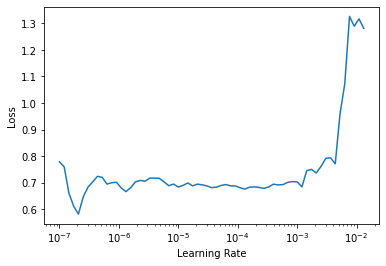

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5,5e-7)

epoch,train_loss,valid_loss,accuracy,time
0,0.736546,0.696243,0.583333,00:12
1,0.704871,0.684703,0.500000,00:12
2,0.701889,0.714634,0.500000,00:12
3,0.715317,0.753375,0.416667,00:12
4,0.708447,0.687403,0.583333,00:12


In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=0.013182567432522774)

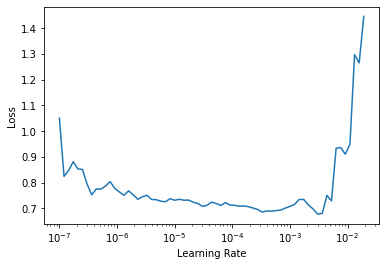

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5,5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.652417,1.367578,0.333333,00:12
1,0.837393,1.956792,0.666667,00:12
2,1.131637,0.847366,0.750000,00:12
3,1.120085,0.815528,0.416667,00:12
4,1.013156,0.749667,0.500000,00:12


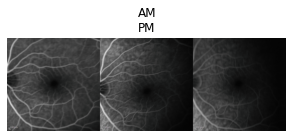

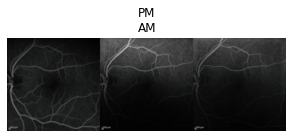

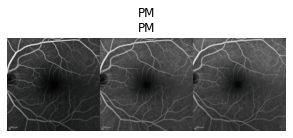

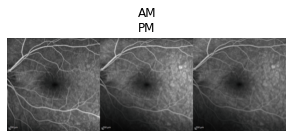

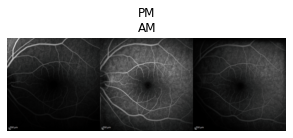

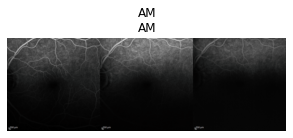

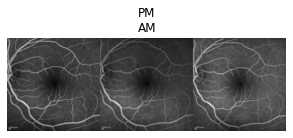

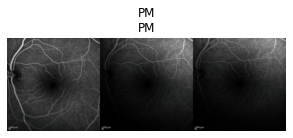

In [ ]:
learn.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

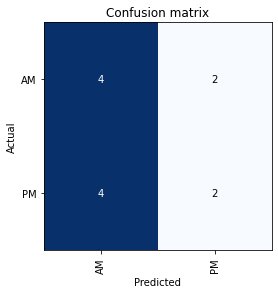

In [ ]:
interp.plot_confusion_matrix()

##Densesnet121 of previous work 

In [ ]:
model = ConvLSTM(arch = densenet121, weights_file='/content/drive/My Drive/Copy of Final-Eye1-without-quantum-Densenet121-stage-3.pth', num_classes=2, hidden_dim=1024, lstm_layers=2, bidirectional=False, attention=False)

In [ ]:
learn = Learner(dls, model, metrics=[accuracy], wd=0.1, cbs=[ModelResetter()], splitter=convlstm_splitter ).to_fp16()
learn.freeze()

In [ ]:
learn.summary()

##Some experiment

In [ ]:
modell = create_cnn_model(resnet34, n_out=1, n_in=3, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
modell[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=1, bias=False)
)

In [ ]:
modell[1][0:3]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
num_features_model(nn.Sequential(*modell[0].children()))

512

#CNN-LSTM with Bidirectional

In [ ]:
model2 = ConvLSTM(num_classes=dls.c, hidden_dim=256, lstm_layers=2, bidirectional=True, attention=True)

In [ ]:
learn2 = Learner(dls, model2, metrics=[accuracy], wd=0.1, cbs=[ModelResetter()], splitter=convlstm_splitter).to_fp16()
learn2.freeze()

In [ ]:
learn2.summary()

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=0.019054606556892395)

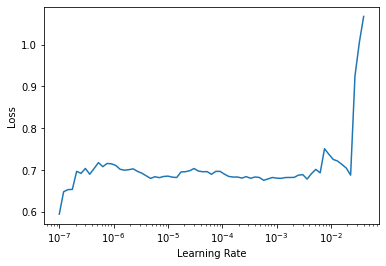

In [ ]:
learn2.lr_find()

In [ ]:
learn2.fit_one_cycle(5,5e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.736037,0.706670,0.416667,00:12
1,0.719328,0.750880,0.500000,00:12
2,0.711799,0.744499,0.500000,00:12
3,0.696426,0.705183,0.583333,00:12
4,0.686229,0.719467,0.416667,00:12


SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=0.0691830962896347)

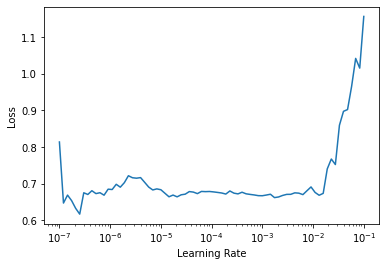

In [ ]:
learn2.lr_find()

In [ ]:
learn2.fit_one_cycle(5,5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.642963,0.665694,0.583333,00:12
1,0.682259,0.692229,0.416667,00:12
2,0.673074,0.708409,0.500000,00:12
3,0.684434,0.675108,0.666667,00:12
4,0.683668,0.677551,0.666667,00:12


In [ ]:
interp2 = ClassificationInterpretation.from_learner(learn2)

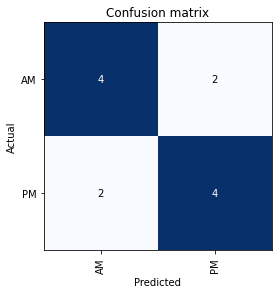

In [ ]:
interp2.plot_confusion_matrix()

SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=0.04786301031708717)

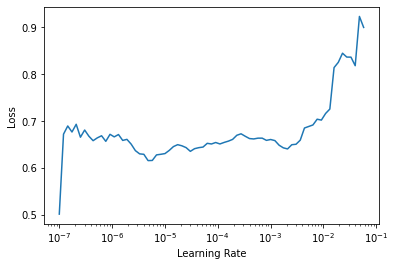

In [ ]:
learn2.lr_find()

In [ ]:
learn2.unfreeze()

SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=0.0831763744354248)

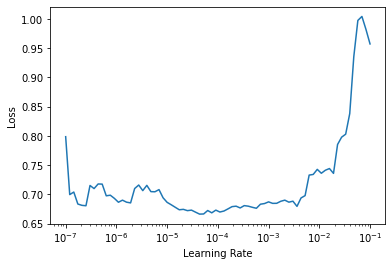

In [ ]:
learn2.lr_find()

In [ ]:
learn2.fit_one_cycle(5,slice(5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.722153,0.746720,0.583333,00:13
1,0.779945,0.722132,0.500000,00:13
2,0.735498,0.825420,0.583333,00:13
3,0.704024,0.755365,0.416667,00:13
4,0.656431,0.785872,0.416667,00:13
